In [1]:
import seaborn as sns #library for data visualization
import numpy as np # library to handle data in a vectorized manner
import pandas as pd #library for data analsysis
import requests #library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize #tranform JSON file into a pandas dataframe

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
#newyork_data

In [5]:
neighborhoods_data = newyork_data['features']

### Transforming the data into a pandas dataframe

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods['Borough'].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Visualizing the amount of neighborhoods in each Borough

Text(0.5, 1.0, 'Amount of Neighborhoods in Each Borough')

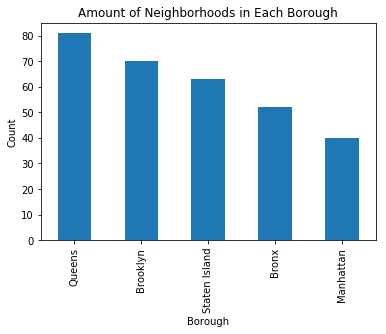

In [9]:
ax = neighborhoods['Borough'].value_counts().plot(kind = 'bar')
ax.set_ylabel('Count')
ax.set_xlabel('Borough')
ax.set_title('Amount of Neighborhoods in Each Borough')

In [10]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent = "ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

### Map of New York City with Different Neighborhoods

In [11]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### API Information

In [12]:
CLIENT_ID = 'KFYVRGLRHWZ3F5QOMHQ3KYKJWK1SRX02X4UCRYLBGR3CTX1O' # your Foursquare ID
CLIENT_SECRET = 'LNVN4HIUS0Q2AKP5A1K2RRRC5QLXMYGXIVKISAREM3ISV0WZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [13]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    radius = 400
    LIMIT = 100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data = results['response']['groups'][0]['items']
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['venue']['id']
            venue_name = row['venue']['name']
            venue_category = row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data = results['response']['venue']
    venue_details = []
    try:
        venue_id = venue_data['id']
        venue_name = venue_data['name']
        venue_likes = venue_data['likes']['count']
        venue_rating = venue_data['rating']
        venue_tips = venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names = ['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url = 'https://cocl.us/new_york_dataset'
    resp = requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [14]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
column_names = ['Borough', 'Neighborhood', 'ID','Name']
ny_sushi = pd.DataFrame(columns = column_names)

for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    sushi_resturants = venues[venues['Category'] == 'Sushi Restaurant']
    for resturant_detail in sushi_resturants.values.tolist():
        id, name , category = resturant_detail
        ny_sushi = ny_sushi.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)


In [16]:
ny_sushi.head()

,Borough,Neighborhood,ID,Name
0,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House
1,Brooklyn,Bay Ridge,519432c7498eae4af99449fd,Inaka
2,Brooklyn,Greenpoint,49d798e9f964a520395d1fe3,Sakura 6
3,Brooklyn,Greenpoint,5a98492083e3807c830d584e,KanaHashi
4,Brooklyn,Brighton Beach,4ac43a28f964a520799e20e3,Sachiko Sushi


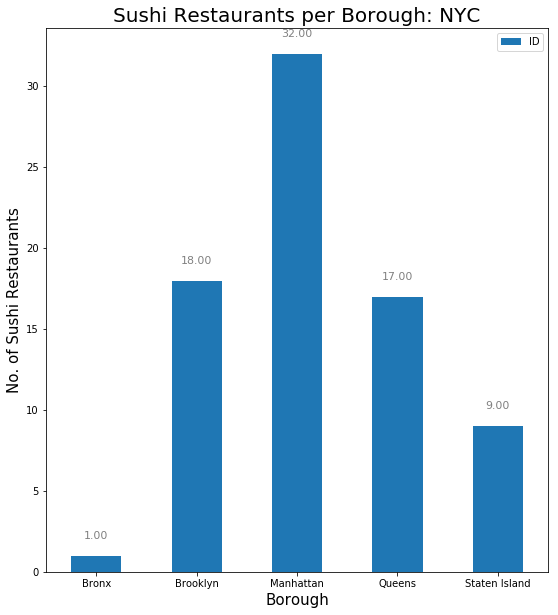

In [17]:
ax3 = ny_sushi.groupby('Borough')['ID'].count().plot(kind = 'bar', figsize = (9,10))
for p in ax3.patches:
             ax3.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
plt.title('Sushi Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Sushi Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [18]:
ny_sushi[ny_sushi['Borough'] == 'Bronx']

,Borough,Neighborhood,ID,Name
0,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House


In [19]:
ny_sushi[ny_sushi['Borough'] == 'Brooklyn'].head()

,Borough,Neighborhood,ID,Name
1,Brooklyn,Bay Ridge,519432c7498eae4af99449fd,Inaka
2,Brooklyn,Greenpoint,49d798e9f964a520395d1fe3,Sakura 6
3,Brooklyn,Greenpoint,5a98492083e3807c830d584e,KanaHashi
4,Brooklyn,Brighton Beach,4ac43a28f964a520799e20e3,Sachiko Sushi
5,Brooklyn,Brighton Beach,4a5f5918f964a5206dbf1fe3,Umi Japanese Cuisine


In [20]:
ny_sushi[ny_sushi['Borough'] == 'Manhattan'].head()

,Borough,Neighborhood,ID,Name
19,Manhattan,Washington Heights,4a4a642cf964a520bdab1fe3,Sushi Yu II
20,Manhattan,Hamilton Heights,5674592d498e85f07427e61b,Chopped Parsley
21,Manhattan,Upper East Side,5a8c6e6fb6b04b2d4e648ccb,Sushi Noz
22,Manhattan,Upper East Side,4aa29d9cf964a520f94120e3,Amber
23,Manhattan,Yorkville,4a0d5a23f964a52077751fe3,Poke Restaurant


In [21]:
ny_sushi[ny_sushi['Borough'] == 'Queens'].head()

,Borough,Neighborhood,ID,Name
43,Queens,Jackson Heights,4b7c90acf964a520569b2fe3,Tomo Japanese Cuisine
44,Queens,Elmhurst,5a418721b0405637687d4272,Akino
45,Queens,Howard Beach,4b77410cf964a5200e8c2ee3,Frenasia
46,Queens,Flushing,4c583966d12a20a1647168bd,Sushi Family
47,Queens,Maspeth,4c8ad28052a98cfaa66530e9,Sakura 7


In [22]:
ny_sushi[ny_sushi['Borough'] == 'Staten Island'].head()

,Borough,Neighborhood,ID,Name
57,Staten Island,New Dorp,4b89bfbff964a5205e4d32e3,Nori
58,Staten Island,Great Kills,4e4e63b7bd4101d0d7a91168,Lucky Fortune Sushi
59,Staten Island,Eltingville,4bc0e24bb492d13a2417a560,Kiku Sushi
60,Staten Island,Eltingville,4bda0cbfaae4ef3b3dcc6ec6,TOMO Japanese Cuisine
61,Staten Island,Annadale,53ebf523498ee86ebe0de1e9,Ocean Sushi


In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
sushi_stats = pd.DataFrame(columns=column_names)
count = 1
for row in ny_sushi.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        id,name,likes,rating,tips=[0]*5
    sushi_stats = sushi_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5f545f1ad04dfc25dafac492'}, 'response': {'venue': {'id': '4baa9c97f964a52088793ae3', 'name': 'Tokyo House', 'contact': {'phone': '7186016877', 'formattedPhone': '(718) 601-6877'}, 'location': {'address': '5648 Riverdale Ave', 'lat': 40.90567203906053, 'lng': -73.90430870547758, 'labeledLatLngs': [{'label': 'display', 'lat': 40.90567203906053, 'lng': -73.90430870547758}, {'label': 'entrance', 'lat': 40.9057, 'lng': -73.904229}], 'postalCode': '10471', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5648 Riverdale Ave', 'Bronx, NY 10471', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tokyo-house/4baa9c97f964a52088793ae3', 'categories': [{'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant', 'pluralName': 'Sushi Restaurants', 'shortName': 'Sushi', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/sushi_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d111941

In [24]:
sushi_stats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House,15,7.7,7
1,Brooklyn,Bay Ridge,519432c7498eae4af99449fd,Inaka,9,7.3,6
2,Brooklyn,Greenpoint,49d798e9f964a520395d1fe3,Sakura 6,74,7.5,36
3,Brooklyn,Greenpoint,5a98492083e3807c830d584e,KanaHashi,11,6.9,3
4,Brooklyn,Brighton Beach,4ac43a28f964a520799e20e3,Sachiko Sushi,9,7.5,8


In [25]:
sushi_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 7 columns):
Borough         77 non-null object
Neighborhood    77 non-null object
ID              77 non-null object
Name            77 non-null object
Likes           77 non-null object
Rating          77 non-null float64
Tips            77 non-null object
dtypes: float64(1), object(6)
memory usage: 4.3+ KB


In [26]:
sushi_stats['Likes'] = sushi_stats['Likes'].astype('float64')
sushi_stats['Tips'] = sushi_stats['Tips'].astype('float64')

In [27]:
sushi_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 7 columns):
Borough         77 non-null object
Neighborhood    77 non-null object
ID              77 non-null object
Name            77 non-null object
Likes           77 non-null float64
Rating          77 non-null float64
Tips            77 non-null float64
dtypes: float64(3), object(4)
memory usage: 4.3+ KB


In [28]:
sushi_stats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House,15.0,7.7,7.0
1,Brooklyn,Bay Ridge,519432c7498eae4af99449fd,Inaka,9.0,7.3,6.0
2,Brooklyn,Greenpoint,49d798e9f964a520395d1fe3,Sakura 6,74.0,7.5,36.0
3,Brooklyn,Greenpoint,5a98492083e3807c830d584e,KanaHashi,11.0,6.9,3.0
4,Brooklyn,Brighton Beach,4ac43a28f964a520799e20e3,Sachiko Sushi,9.0,7.5,8.0


In [29]:
sushi_stats[sushi_stats['Borough'] == 'Bronx'].mean()

Likes     15.0
Rating     7.7
Tips       7.0
dtype: float64

There is only one sushi resturant in the Bronx neighborhood

In [30]:
sushi_stats[sushi_stats['Borough'] == 'Bronx']

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House,15.0,7.7,7.0


The only sushi resturant in Bronx is Tokyo House. It is in the North Riverdale neighborhood.

In [31]:
sushi_stats[sushi_stats['Borough'] == 'Brooklyn'].mean()

Likes     83.222222
Rating     6.833333
Tips      30.222222
dtype: float64

In [32]:
sushi_stats[sushi_stats['Borough'] == 'Brooklyn'].shape

(18, 7)

In [33]:
sushi_stats[sushi_stats['Borough'] == 'Manhattan'].mean()

Likes     149.00000
Rating      8.11875
Tips       56.81250
dtype: float64

In [34]:
sushi_stats[sushi_stats['Borough'] == 'Queens'].mean()

Likes     25.117647
Rating     6.935294
Tips      14.058824
dtype: float64

In [35]:
sushi_stats[sushi_stats['Borough'] == 'Staten Island'].mean()

Likes     11.111111
Rating     5.822222
Tips       9.222222
dtype: float64

In [36]:
sushi_stats.head(5)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House,15.0,7.7,7.0
1,Brooklyn,Bay Ridge,519432c7498eae4af99449fd,Inaka,9.0,7.3,6.0
2,Brooklyn,Greenpoint,49d798e9f964a520395d1fe3,Sakura 6,74.0,7.5,36.0
3,Brooklyn,Greenpoint,5a98492083e3807c830d584e,KanaHashi,11.0,6.9,3.0
4,Brooklyn,Brighton Beach,4ac43a28f964a520799e20e3,Sachiko Sushi,9.0,7.5,8.0


In [37]:
ratings = sushi_stats[['Borough', 'Neighborhood', 'ID', 'Name', 'Rating']]
ratings.head(5)

,Borough,Neighborhood,ID,Name,Rating
0,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House,7.7
1,Brooklyn,Bay Ridge,519432c7498eae4af99449fd,Inaka,7.3
2,Brooklyn,Greenpoint,49d798e9f964a520395d1fe3,Sakura 6,7.5
3,Brooklyn,Greenpoint,5a98492083e3807c830d584e,KanaHashi,6.9
4,Brooklyn,Brighton Beach,4ac43a28f964a520799e20e3,Sachiko Sushi,7.5


In [38]:
ratings.groupby('Borough').mean()

,Rating
Borough,
Bronx,7.700000
Brooklyn,6.833333
Manhattan,8.118750
Queens,6.935294
Staten Island,5.822222


### A visualization of the average ratings of sushi resturants in NYC Boroughs

Text(0.5, 1.0, 'Average Ratings of Sushi Resturants by Borough')

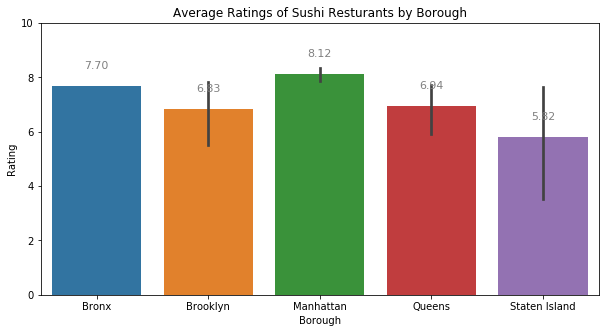

In [39]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = ratings, x = 'Borough', y = 'Rating')
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
ax.set_ylim(0,10)
plt.title('Average Ratings of Sushi Resturants by Borough')

In [40]:
ratings.iloc[ratings['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              5a0e475b018cbb6a2196479e
Name                        Sushi By Bou
Rating                               9.2
Name: 73, dtype: object

### Creating a data set with the average rating of each Sushi resturant for each neighborhood

In [41]:
avg_rate = ratings.groupby('Neighborhood', as_index = False).mean()[['Neighborhood', 'Rating']]
avg_rate.columns = ['Neighborhood', 'Average Rating']
avg_rate.sort_values(['Average Rating'], ascending = False).head()

,Neighborhood,Average Rating
17,Flatiron,9.2
41,Prospect Heights,9.1
38,North Side,9.0
54,West Village,9.0
44,South Side,9.0


### Get the top neighborhoods that have their average sushi rating above 8

In [42]:
top_n = avg_rate[avg_rate['Average Rating'] >= 8]
top_n.sort_values(['Average Rating'], ascending = False)

,Neighborhood,Average Rating
17,Flatiron,9.200000
41,Prospect Heights,9.100000
38,North Side,9.000000
54,West Village,9.000000
44,South Side,9.000000
23,Greenwich Village,8.966667
46,Sunnyside Gardens,8.750000
50,Turtle Bay,8.700000
49,Tudor City,8.700000
48,Tribeca,8.700000


In [43]:
top_n = pd.merge(top_n, ratings, on = 'Neighborhood')
top_n = top_n.drop_duplicates()

#### The top_n is a merged data set from the code above to get all necessary information. It has the average rating for each neighborhood that is above 8 so it does contain resturants that have ratings below 8. 

In [44]:
top_n.shape

(29, 6)

In [45]:
top_n[top_n['Borough'] == 'Manhattan'].describe()

,Average Rating,Rating
count,18.000000,18.000000
mean,8.583333,8.583333
std,0.322976,0.443582
min,8.250000,7.500000
25%,8.300000,8.325000
50%,8.500000,8.700000
75%,8.900000,8.950000
max,9.200000,9.200000


In [46]:
top_n[top_n['Borough'] == 'Staten Island'].describe()

,Average Rating,Rating
count,2.000000,2.000000
mean,8.150000,8.150000
std,0.212132,0.212132
min,8.000000,8.000000
25%,8.075000,8.075000
50%,8.150000,8.150000
75%,8.225000,8.225000
max,8.300000,8.300000


In [47]:
top_n[top_n['Borough'] == 'Queens'].describe()

,Average Rating,Rating
count,4.000000,4.000000
mean,8.475000,8.475000
std,0.327872,0.330404
min,8.100000,8.100000
25%,8.250000,8.250000
50%,8.525000,8.500000
75%,8.750000,8.725000
max,8.750000,8.800000


In [48]:
top_n[top_n['Borough'] == 'Bronx'].shape

(0, 6)

In [49]:
top_n[top_n['Borough'] == 'Brooklyn'].describe()

,Average Rating,Rating
count,5.000000,5.000000
mean,8.840000,8.840000
std,0.270185,0.270185
min,8.500000,8.500000
25%,8.600000,8.600000
50%,9.000000,9.000000
75%,9.000000,9.000000
max,9.100000,9.100000


In [50]:
top_n.sort_values(by = 'Rating', ascending = False)

,Neighborhood,Average Rating,Borough,ID,Name,Rating
7,Flatiron,9.200000,Manhattan,5a0e475b018cbb6a2196479e,Sushi By Bou,9.2
9,Greenwich Village,8.966667,Manhattan,555e7399498eccd4b34fe416,DomoDomo,9.1
20,Prospect Heights,9.100000,Brooklyn,49f50c9ff964a5208a6b1fe3,Gen,9.1
21,South Side,9.000000,Brooklyn,423e0e80f964a52048201fe3,Bozu,9.0
11,Greenwich Village,8.966667,Manhattan,45ac12d6f964a5205d411fe3,Blue Ribbon Sushi,9.0
19,North Side,9.000000,Brooklyn,423e0e80f964a52048201fe3,Bozu,9.0
4,Civic Center,8.250000,Manhattan,4a8f2f39f964a520471420e3,Takahachi,9.0
27,West Village,9.000000,Manhattan,52155e9d11d2c369404df14e,Sushi Nakazawa,9.0
10,Greenwich Village,8.966667,Manhattan,3fd66200f964a5200eea1ee3,Tomoe Sushi,8.8
22,Sunnyside Gardens,8.750000,Queens,4a6f1c00f964a52054d51fe3,TJ Asian Bistro,8.8


The best sushi resturants are found most commonly in Manhattan

## Manhattan

In [51]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### Map of Manhattan

In [52]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [53]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [54]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

In [55]:
LIMIT = 100 
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=KFYVRGLRHWZ3F5QOMHQ3KYKJWK1SRX02X4UCRYLBGR3CTX1O&client_secret=LNVN4HIUS0Q2AKP5A1K2RRRC5QLXMYGXIVKISAREM3ISV0WZ&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

In [56]:
results = requests.get(url).json()

In [57]:
#function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [58]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [60]:
man_venues = getNearbyVenues(names = manhattan_data['Neighborhood'],
                          latitudes = manhattan_data['Latitude'],
                          longitudes = manhattan_data['Longitude']
                          )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [61]:
man_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [62]:
man_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,65,65,65,65,65,65
Carnegie Hill,93,93,93,93,93,93
Central Harlem,44,44,44,44,44,44
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,44,44,44,44,44,44
East Village,100,100,100,100,100,100


### Analyze Each Neighborhood

In [63]:
# one hot encoding
manhattan_onehot = pd.get_dummies(man_venues[['Venue Category']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = man_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [64]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.015385,0.0,0.000000,0.000000
1,Carnegie Hill,0.0,0.0,0.000000,0.000000,0.0,0.00,0.010753,0.000000,0.010753,...,0.0,0.010753,0.0,0.0,0.0,0.010753,0.032258,0.0,0.010753,0.032258
2,Central Harlem,0.0,0.0,0.068182,0.045455,0.0,0.00,0.000000,0.022727,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,Chelsea,0.0,0.0,0.000000,0.040000,0.0,0.01,0.000000,0.040000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.010000,0.0,0.010000,0.000000
4,Chinatown,0.0,0.0,0.000000,0.030000,0.0,0.00,0.000000,0.000000,0.000000,...,0.0,0.020000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [65]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [66]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Playground,Sandwich Place,Shopping Mall,Food Court,Gourmet Shop
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Pizza Place,Bookstore,Cosmetics Shop,French Restaurant,Gym,Gym / Fitness Center,Italian Restaurant
2,Central Harlem,African Restaurant,Chinese Restaurant,Cosmetics Shop,American Restaurant,French Restaurant,Bar,Seafood Restaurant,Grocery Store,Event Space,Tapas Restaurant
3,Chelsea,Coffee Shop,American Restaurant,Art Gallery,Italian Restaurant,Ice Cream Shop,Bakery,French Restaurant,Cupcake Shop,Park,Theater
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Dessert Shop,Noodle House,Salon / Barbershop,Optical Shop,Spa,Hotpot Restaurant,American Restaurant


### Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [68]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 1, 1, 1, 3, 3, 0, 0, 3], dtype=int32)

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Coffee Shop,Discount Store,Gym,Sandwich Place,Yoga Studio,Big Box Store,Tennis Stadium,Supplement Shop,Donut Shop,Kids Store
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Bakery,Cocktail Bar,Dessert Shop,Noodle House,Salon / Barbershop,Optical Shop,Spa,Hotpot Restaurant,American Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Café,Bakery,Mobile Phone Shop,Coffee Shop,Tapas Restaurant,New American Restaurant,Latin American Restaurant,Supplement Shop,Park,Gym
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Restaurant,Lounge,Café,Chinese Restaurant,Wine Bar,American Restaurant,Deli / Bodega,Bakery,Spanish Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Latin American Restaurant,Indian Restaurant,Sushi Restaurant,Park,Deli / Bodega,Sandwich Place


In [70]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

In [71]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Inwood,Mexican Restaurant,Restaurant,Lounge,Café,Chinese Restaurant,Wine Bar,American Restaurant,Deli / Bodega,Bakery,Spanish Restaurant
4,Hamilton Heights,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Latin American Restaurant,Indian Restaurant,Sushi Restaurant,Park,Deli / Bodega,Sandwich Place
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Sandwich Place,Deli / Bodega,Pizza Place,Latin American Restaurant,Pharmacy,Liquor Store,Coffee Shop
19,East Village,Bar,Mexican Restaurant,Pizza Place,Wine Bar,Cocktail Bar,Ice Cream Shop,Italian Restaurant,Speakeasy,Korean Restaurant,Vegetarian / Vegan Restaurant
25,Manhattan Valley,Coffee Shop,Bar,Yoga Studio,Mexican Restaurant,Thai Restaurant,Playground,Pizza Place,Bubble Tea Shop,Café,Peruvian Restaurant
27,Gramercy,Bar,Italian Restaurant,American Restaurant,Pizza Place,Bagel Shop,Coffee Shop,Cocktail Bar,Playground,Mexican Restaurant,Thrift / Vintage Store


In [72]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Dessert Shop,Noodle House,Salon / Barbershop,Optical Shop,Spa,Hotpot Restaurant,American Restaurant
5,Manhattanville,Seafood Restaurant,Coffee Shop,Italian Restaurant,Mexican Restaurant,Deli / Bodega,Supermarket,Spanish Restaurant,Bus Station,Café,Chinese Restaurant
6,Central Harlem,African Restaurant,Chinese Restaurant,Cosmetics Shop,American Restaurant,French Restaurant,Bar,Seafood Restaurant,Grocery Store,Event Space,Tapas Restaurant
9,Yorkville,Italian Restaurant,Coffee Shop,Gym,Bar,Sushi Restaurant,Wine Shop,Deli / Bodega,Diner,Japanese Restaurant,Bagel Shop
10,Lenox Hill,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Cocktail Bar,Gym / Fitness Center,Café,Gym,Burger Joint,Thai Restaurant
12,Upper West Side,Italian Restaurant,Bar,Café,Wine Bar,Pizza Place,Coffee Shop,Vegetarian / Vegan Restaurant,Indian Restaurant,Ice Cream Shop,Middle Eastern Restaurant
13,Lincoln Square,Plaza,Café,Theater,Concert Hall,Performing Arts Venue,Italian Restaurant,French Restaurant,Gym / Fitness Center,Indie Movie Theater,Coffee Shop
17,Chelsea,Coffee Shop,American Restaurant,Art Gallery,Italian Restaurant,Ice Cream Shop,Bakery,French Restaurant,Cupcake Shop,Park,Theater
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Clothing Store,Boutique,Gym,Dessert Shop,Café,Chinese Restaurant,Coffee Shop,Seafood Restaurant
23,Soho,Clothing Store,Italian Restaurant,Coffee Shop,Boutique,Bakery,Mediterranean Restaurant,Shoe Store,Seafood Restaurant,Salon / Barbershop,Pizza Place


In [73]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Gym,Sandwich Place,Yoga Studio,Big Box Store,Tennis Stadium,Supplement Shop,Donut Shop,Kids Store


In [74]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Bakery,Mobile Phone Shop,Coffee Shop,Tapas Restaurant,New American Restaurant,Latin American Restaurant,Supplement Shop,Park,Gym
8,Upper East Side,Italian Restaurant,Coffee Shop,Bakery,Exhibit,Gym / Fitness Center,Spa,Cosmetics Shop,French Restaurant,Hotel,Juice Bar
14,Clinton,Theater,American Restaurant,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Sandwich Place,Spa,Wine Shop,Hotel,Gym
15,Midtown,Hotel,Clothing Store,Bakery,Coffee Shop,Steakhouse,Theater,Cosmetics Shop,Bookstore,Café,Sandwich Place
16,Murray Hill,Coffee Shop,Sandwich Place,Japanese Restaurant,American Restaurant,Gym / Fitness Center,Hotel,Gym,Pizza Place,Restaurant,Steakhouse
20,Lower East Side,Chinese Restaurant,Japanese Restaurant,Pizza Place,Bakery,Ramen Restaurant,Art Gallery,Café,Coffee Shop,Yoga Studio,Bubble Tea Shop
21,Tribeca,American Restaurant,Park,Italian Restaurant,Coffee Shop,Wine Shop,Wine Bar,Spa,Café,Greek Restaurant,Scenic Lookout
22,Little Italy,Bakery,Café,Coffee Shop,Italian Restaurant,Ice Cream Shop,Cocktail Bar,Chinese Restaurant,Bubble Tea Shop,Mediterranean Restaurant,Pizza Place
28,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Playground,Sandwich Place,Shopping Mall,Food Court,Gourmet Shop
29,Financial District,Coffee Shop,Hotel,Cocktail Bar,American Restaurant,Pizza Place,Café,Steakhouse,Food Truck,Mexican Restaurant,Salad Place


In [75]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Roosevelt Island,Park,Dry Cleaner,Outdoors & Recreation,Baseball Field,Gym / Fitness Center,Food & Drink Shop,Sandwich Place,Liquor Store,Greek Restaurant,Playground
37,Stuyvesant Town,Park,Fountain,Boat or Ferry,Cocktail Bar,Coffee Shop,Harbor / Marina,Baseball Field,Bar,Bistro,Heliport


In [76]:
top_n['Borough'].value_counts()

Manhattan        18
Brooklyn          5
Queens            4
Staten Island     2
Name: Borough, dtype: int64